### Import necessary libraries

In [ ]:
# Standard libraries
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# Scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Prepare the dataset

In [ ]:
# Load the MNIST dataset and split into features (X) and labels (y)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']
y = y.astype(int)  # Ensure labels are integer-encoded

# Split into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Vectorize the images by flattening them into 1D arrays
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Perform a stratified split to create a validation set from the training data
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

### Define the model building function for Keras Tuner

In [ ]:
def build_model(hp):
    model = keras.models.Sequential()

    # Input layer for 784-dimensional vector input
    model.add(keras.layers.InputLayer(input_shape=(784,)))

    # Tune the number of hidden layers and units in each layer with dropout and batch normalization
    for i in range(hp.Int('num_layers', 3, 5)):  # Tune between 3 and 5 hidden layers
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64)  # Tune between 128 and 512 units
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'silu'])))
        # Tune Dropout Rates for Regularization, including 0.4 in the range
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.3, step=0.05)))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Compile the model with a tuned learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',  # For integer-encoded labels
        metrics=['accuracy']
    )

    return model


### Fine tuning the model

In [ ]:
# Instantiate the Keras Tuner for hyperparameter search keep the epochs print in the output
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train in each trial
    directory='directory_0',  # Directory to save the search results
    project_name='mnist_keras_tuner',
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=10,  # Increase patience
    restore_best_weights=True  # Restore best weights on the validation set
)

# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Start the search, passing callbacks directly to the search function
tuner.search(
    X_train_part, y_train_part,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping, lr_scheduler],  # Pass the callback directly
)

Trial 25 Complete [00h 18m 18s]
val_accuracy: 0.9837499856948853

Best val_accuracy So Far: 0.9859166741371155
Total elapsed time: 05h 37m 13s


### Best parameters

In [ ]:
# Printing best parameters
best_hps_dict = best_hps.values
df = pd.DataFrame.from_dict(best_hps_dict, orient='index', columns=['Value']) # Create DataFrame with values as a column
df.index.name = 'Hyperparameter' # Set index name to 'Hyperparameter'
df

,Value
Hyperparameter,
num_layers,3
units_0,448
activation_0,silu
dropout_0,0.15
units_1,192
activation_1,relu
dropout_1,0.15
units_2,320
activation_2,relu


### Training the fine-tuned model

In [ ]:
# Retrieve the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Print the model summary
model.summary()

# Define early stopping callback to monitor training accuracy
early_stopping = EarlyStopping(
    monitor="accuracy",
    patience=10,
    restore_best_weights=True
)

# Define learning rate reduction callback to prevent divergence in later epochs
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",    # Monitor validation loss to reduce learning rate
    factor=0.5,            # Reduce the learning rate by half
    patience=5,            # Wait 5 epochs before reducing
    min_lr=1e-6,           # Set a minimum learning rate
    verbose=1              # Print messages during training
)

# Train the model on the full training data and track training time
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=37,
    batch_size=32,
    validation_split=0.1,
    callbacks=[reduce_lr]
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:,.3f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 448)                 │         351,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 448)                 │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 192)                 │          86,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 320)                 │          61,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 320)                 │           1,280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           3,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,698 (1.93 MB)

 Trainable params: 504,778 (1.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.8712 - loss: 0.4193 - val_accuracy: 0.9702 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 2/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.9515 - loss: 0.1586 - val_accuracy: 0.9760 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 3/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9637 - loss: 0.1189 - val_accuracy: 0.9775 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 4/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9708 - loss: 0.0929 - val_accuracy: 0.9765 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 5/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9745 - loss: 0.0775 - val_accuracy: 0.9790 - val_loss: 0.0782 - learning_rate: 0.0010
Epoch 6/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9797 - loss: 0.0640 - val_accuracy: 0.9817 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 7/37
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accura

In [ ]:
hist = pd.DataFrame(history.history)
hist

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.915963,0.275274,0.970167,0.098480,0.001000
1,0.953944,0.149415,0.976000,0.079614,0.001000
2,0.964667,0.112390,0.977500,0.084249,0.001000
3,0.970926,0.091035,0.976500,0.083348,0.001000
4,0.975444,0.074385,0.979000,0.078208,0.001000
5,0.979444,0.063801,0.981667,0.069336,0.001000
6,0.982444,0.052494,0.982667,0.069186,0.001000
7,0.984574,0.046574,0.980500,0.077879,0.001000
8,0.986796,0.041025,0.983500,0.078639,0.001000
9,0.988241,0.034690,0.981833,0.084382,0.001000


### Plot training and validation accuracy over epochs

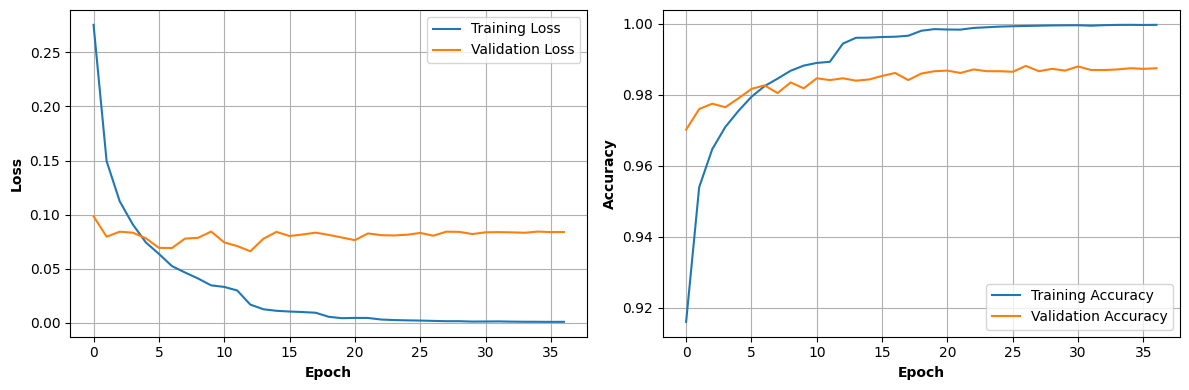

In [ ]:
# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch',  fontweight='bold')
plt.ylabel('Loss',  fontweight='bold')
plt.title('') # Training and Validation Loss
plt.legend()
plt.grid(True) # Add grid to the first subplot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch',  fontweight='bold')
plt.ylabel('Accuracy',  fontweight='bold')
plt.title('') #  Training and Validation Accuracy
plt.legend()
plt.grid(True) # Add grid to the second subplot

plt.tight_layout()
plt.show()

### Plot Learning Rate over Epochs

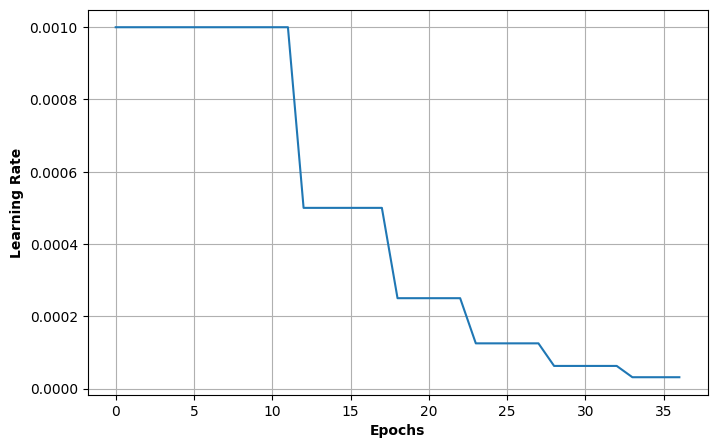

In [ ]:
learning_rate = pd.DataFrame(history.history)['learning_rate']

# plot learning rate with grids
plt.figure(figsize=(8, 5))
plt.plot(learning_rate)
plt.title('') #  Learning Rate
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Learning Rate', fontweight='bold')
plt.grid(True)
plt.show()

### Evaluation Metrics

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Training Time:", training_time)
print('Test loss:', test_loss)

# Overfitting/Underfitting Detection
train_acc = history.history['accuracy'][-1]  # Get final training accuracy
test_acc = accuracy  # Assuming you have test accuracy

# If training accuracy is much higher than test accuracy, it might indicate overfitting.
# If both training and test accuracy are low, it might indicate underfitting.
if train_acc > test_acc + 0.1:  # threshold for overfitting
    print("Potential Overfitting Detected!")
elif train_acc < test_acc - 0.1:  # threshold for underfitting
    print("Potential Underfitting Detected!")
else:
    print("No indication of overfitting or underfitting.")

Test Accuracy: 0.9871
Precision: 0.9871142865769722
Recall: 0.9871
F1-Score: 0.9870998456067506
Training Time: 1073.346001625061
Test loss: 0.08324439078569412
No indication of overfitting or underfitting.


### Utility function

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues, title='Confusion Matrix'):  # Added title parameter
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Now using the title parameter
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label',  fontweight='bold')
    plt.xlabel('Predicted label',  fontweight='bold')
    plt.tight_layout()

### Confusion Matrix (Optional)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


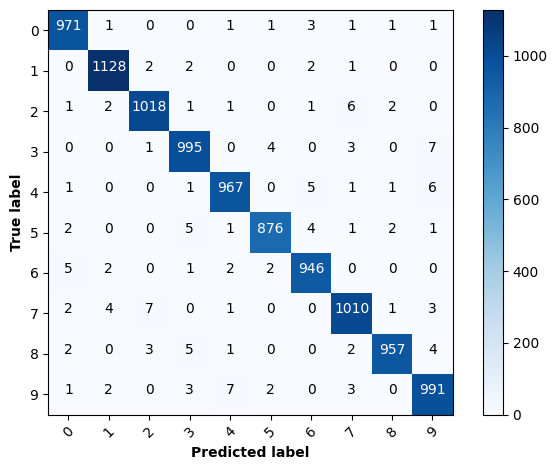

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)

y_test_labels = y_test  # Assign y_test directly to y_test_labels

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plot_confusion_matrix(conf_matrix, classes=range(10), title="")
plt.show()